# NIR Tutorial 

When starting an image-based phenotyping project it is important to consider what the end goals of the project are.
This is important because the goals of the project will determine the the camera type, imaging layout, and will help to 
guide downstream analysis. If it was 
an experiment focused on drought of maize plants and your goal was to get information about water content of plants you
might want to take side-view and top-view images of a single plant with a near-infrared camera.

To run a NIR workflow over a single NIR image there are three required inputs:

1.  **Image:** NIR images are grayscale matrices (1 signal dimension).
In principle, image processing will work on any grayscale image with adjustments if images are well lit and
there is appreciable contrast difference between the object of interest and the background.
2.  **Output directory:** If debug mode is set to 'print' output images from each intermediate step are produced.
3.  **Image of estimated background:** Right now this is hardcoded into the workflow (different background at each zoom level) and not implemented as an argument.


In [1]:
import cv2
from plantcv import plantcv as pcv


In [2]:
class options:
    def __init__(self):
        self.image = "img/NIR_SV_0.png"
        self.debug = "plot"
        self.writeimg= False
        self.result = "nir_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


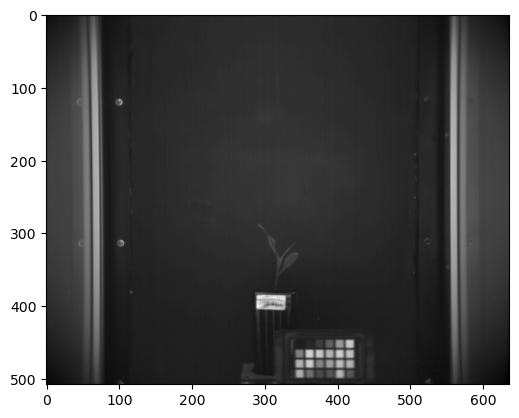

In [3]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)


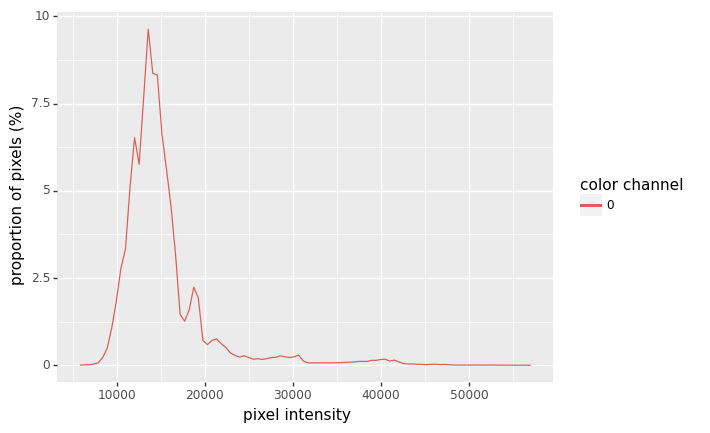

In [4]:
# Visualize histogram of all pixel values, this helps with gauging threshold levels for segmentation 


# Inputs:
#   img - Image data which is numpy.ndarray, the original image for analysis.
#   mask - Optional binary mask made from selected contours (default mask=None).
#   bins - Number of class to divide spectrum into (default bins=100).
#   lower_bound - lower bound of range to be shown in the histogram (default lower_range=None).
#   upper_bound - upper bound of range to be shown in the histogram.
#   title - The title for the histogram (default title=None)
#   hist_data - Return histogram data if True (default hist_data=False)

fig_histogram = pcv.visualize.histogram(img=img, mask=None, hist_data=False)


This example plant takes up relatively little area within the whole image, so the pixel value range will show up on the histogram with a smaller peak. There are areas of the image that are lighter and darker that we want to exclude, so use a two-sided threshold to trim out the pixels that are "plant" intensity. 

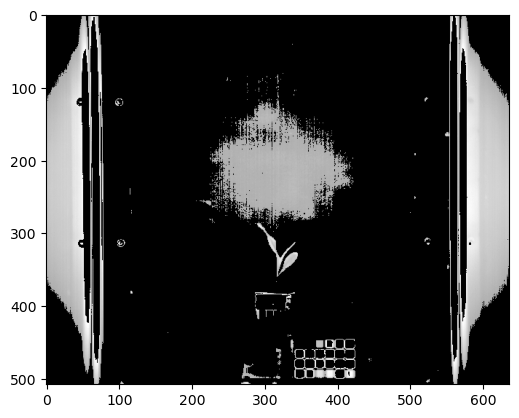

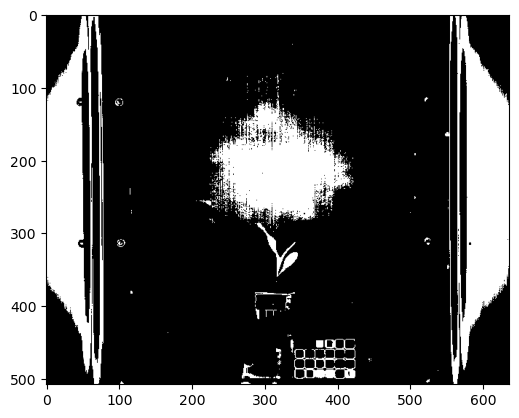

In [5]:
# Threshold the image of interest using the two-sided thresholding function (keep what is between 15950-23500) 
 
# Inputs:
#   rgb_img - RGB image data 
#   lower_thresh - List of lower threshold values 
#   upper_thresh - List of upper threshold values
#   channel - Color-space channels of interest (either 'RGB', 'HSV', 'LAB', or 'gray')
bin_mask, masked_img = pcv.threshold.custom_range(img=img, lower_thresh=[15950], 
                                                           upper_thresh=[23500], channel='gray')



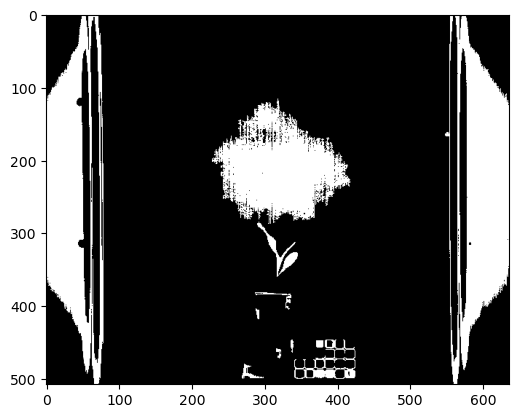

In [6]:
# Use the fill function to get rid of small salt & pepper noise in the image 

# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
cleaned_mask = pcv.fill(bin_img=bin_mask, size=50)


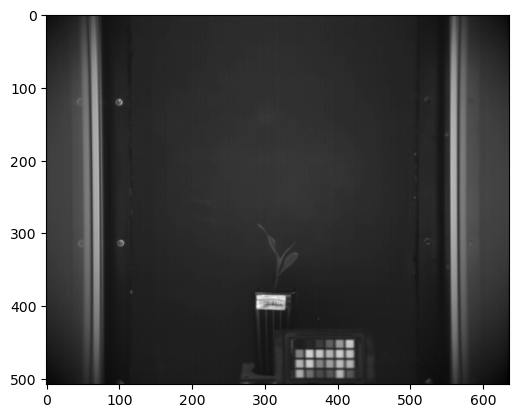

In [7]:
# Original grayscale img is not compatible for plotting with RGB annotations, so create a scaled copy for plotting

# Inputs:
#     gray_img  = Grayscale image data
#     min_value = (optional) new minimum value for range of interest. default = 0
#     max_value = (optional) new maximum value for range of interest. default = 255
scaled_img = pcv.transform.rescale(gray_img=img, min_value=0, max_value=255)


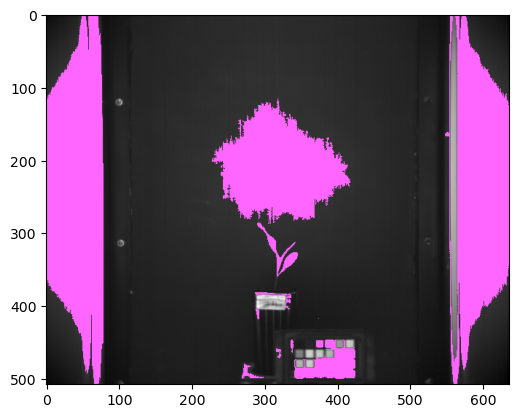

In [8]:
# Identify objects

# Inputs: 
#   img - RGB or grayscale image data for plotting 
#   mask - Binary mask used for detecting contours 
id_objects, obj_hierarchy = pcv.find_objects(img=scaled_img, mask=cleaned_mask)


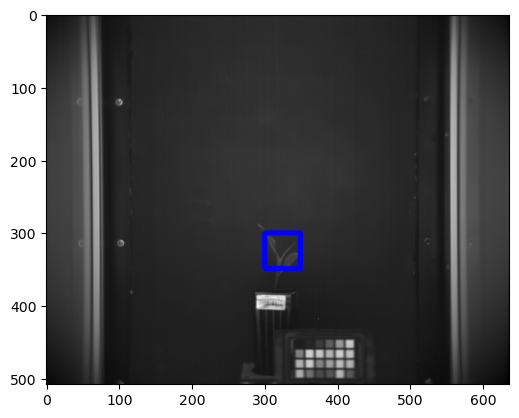

In [9]:
# Define ROI

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi_objects, roi_hierarchy= pcv.roi.rectangle(img=scaled_img, x=300, y=300, h=50, w=50)


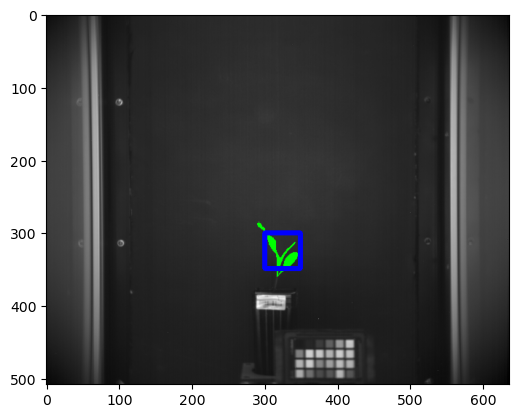

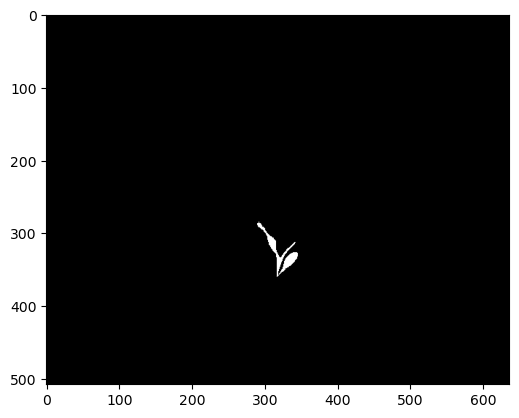

In [10]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
kept_objects, kept_hierarchy, plant_mask, obj_area = pcv.roi_objects(img=scaled_img, roi_contour=roi_objects, 
                                                               roi_hierarchy=roi_hierarchy, object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy, roi_type='partial')


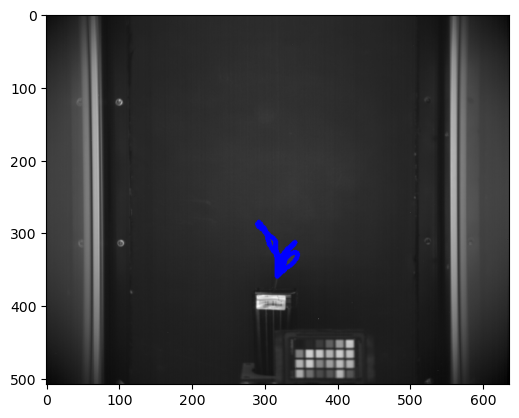

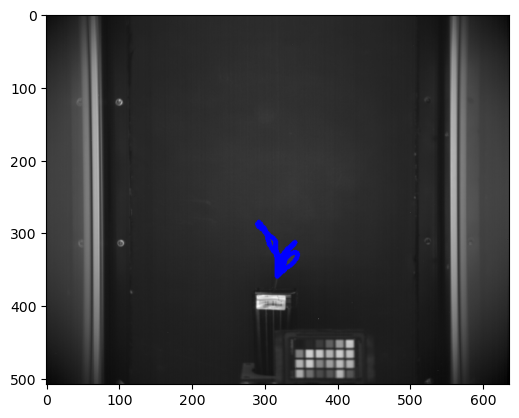

In [11]:
# Use the object_composition function to outline the plant 

# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
grp_object, img_mask = pcv.object_composition(img=scaled_img, contours=kept_objects, 
                                              hierarchy=kept_hierarchy)


Now we can perform the analysis of pixelwise signal value and object shape attributes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


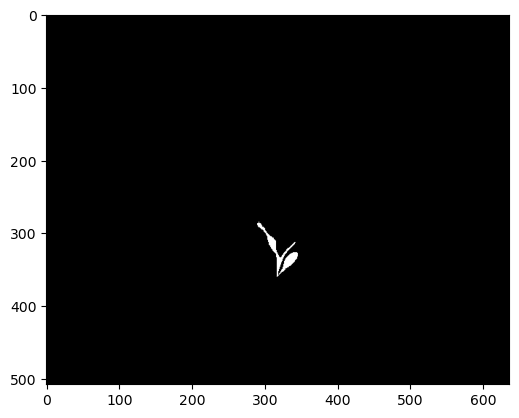

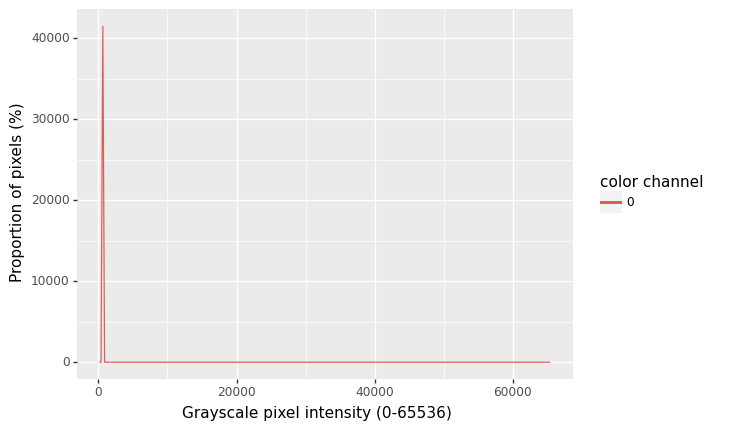

In [17]:
# Perform NIR signal analysis 

# Inputs: 
#   gray_img - 8 or 16-bit grayscale image data 
#   mask - Binary mask made from selected contours 
#   bins - Number of classes to divide the spectrum into 
#   histplot - If True, plots the histogram of intensity values 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

nir_hist_img = pcv.analyze_nir_intensity(gray_img=img, mask=plant_mask, 
                                         bins=256, histplot=True, label="default")



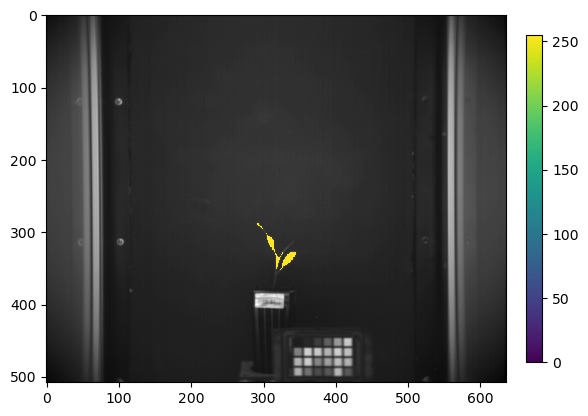

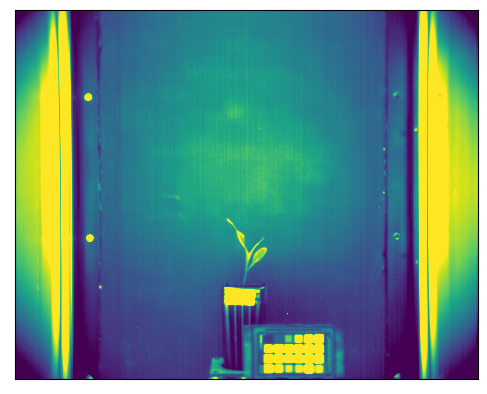

In [19]:
# Pseudocolor the NIR grayscale image 

# Inputs:
#     gray_img - Grayscale image data
#     obj - Single or grouped contour object (optional), if provided the pseudocolored image gets cropped down to the region of interest.
#     mask - Binary mask (optional) 
#     background - Background color/type. Options are "image" (gray_img), "white", or "black". A mask must be supplied.
#     cmap - Colormap
#     min_value - Minimum value for range of interest
#     max_value - Maximum value for range of interest
#     dpi - Dots per inch for image if printed out (optional, if dpi=None then the default is set to 100 dpi).
#     axes - If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
#     colorbar - If False then the colorbar won't be displayed (default colorbar=True)
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=img, obj=None, mask=plant_mask, cmap='viridis')

# Plot with the option background='image'
simple_pseudo_img = pcv.visualize.pseudocolor(gray_img=img, obj=grp_object, mask=None, background="image", 
                                              axes=False, colorbar=False, cmap='viridis', min_value=10000,
                                             max_value=20000)



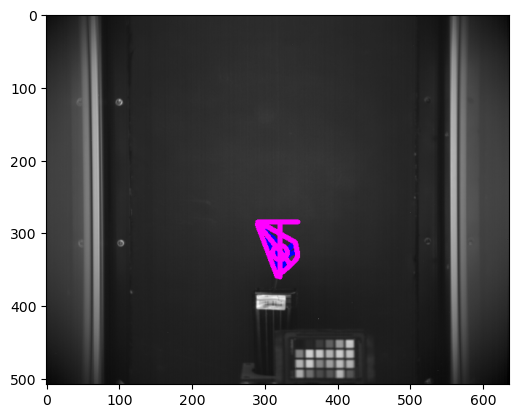

In [14]:
# Perform shape analysis
# First adjust plotting parameters for better visibility of debugging 

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

shape_imgs = pcv.analyze_object(img=scaled_img, obj=grp_object, mask=plant_mask)


In [15]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)


To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) Open the file named “nir_tutorial_results.txt”

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 

